# Rescheduling mit Tardiness (Summe)
> Rescheduling des Tages 1

In [1]:
# Datenzugriff
from configs.path_manager import get_path

# Utils
import src.utils.presenter as show
from src.utils.analize import check_constrains as check
from src.utils.production_process import initialize as init
from src.utils.production_process import filter as process_filter
from src.utils.production_process import gen_deadline as gen_deadline

# Solver Model
from src.models.lp import tardiness_scheduling as lp_tard_schedule
from src.models.lp import tardiness_rescheduling as lp_tard_reschedule
import src.models.heuristics.fcfs as fcfs

# Simulation
from src.simulation.ProductionSimulation import ProductionSimulation

# Extern
import pandas as pd
pd.set_option('display.max_rows', 16)

In [2]:
max_time = 60 * 5 # 5 min

In [3]:
day_count = 1

basic_data_path = get_path("data", "basic")
df_routings = pd.read_csv(basic_data_path / "instance.csv")

df_jssp, df_jobs_arrivals = init.create_jobs_for_shifts(df_routings = df_routings,
                                                        routing_column = "Routing_ID", job_column = "Job",
                                                        shift_count = 1, shift_length = 1440,
                                                        u_b_mmax = 0.94, shuffle = True,
                                                        job_seed=40, arrival_seed=80
                                                       )
df_jobs_times = gen_deadline.get_times_df(df_jssp, df_jobs_arrivals, fcfs.schedule_with_arrivals, target_service=1.0)
df_jobs_times


Schedule-Informationen:
  Makespan: 2319


,Job,Routing_ID,Arrival,Ready Time,Deadline
0,0,9,49,1440,1109.0
1,1,5,130,1440,1104.0
2,2,3,151,1440,1437.0
3,3,4,226,1440,998.0
4,4,6,386,1440,1203.0
...,...,...,...,...,...
15,15,5,1142,1440,2116.0
16,16,6,1254,1440,2071.0
17,17,7,1285,1440,2343.0
18,18,8,1397,1440,2569.0


## I) Complete Scheduling

In [4]:
# Scheduling
df_schedule = lp_tard_schedule.solve_jssp_sum(df_jssp, df_jobs_times, solver= "HiGHS", msg=False, timeLimit=max_time, gapRel= 0.01)
df_schedule

BigM: 6000

Solver-Informationen:
  Summe Tardiness         : 0.0
  Solver-Status           : Optimal
  Anzahl Variablen        : 2140
  Anzahl Constraints      : 4020
  Laufzeit                : ~167 Sekunden


,Job,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Tardiness
0,1,0,130,1104.0,M02,130.0,84.0,214.0,0
1,1,1,130,1104.0,M01,214.0,2.0,216.0,0
2,1,2,130,1104.0,M05,216.0,52.0,268.0,0
3,3,0,226,998.0,M02,226.0,14.0,240.0,0
4,3,1,226,998.0,M00,240.0,6.0,246.0,0
...,...,...,...,...,...,...,...,...,...
195,18,5,1397,2569.0,M09,2329.0,11.0,2340.0,0
196,18,6,1397,2569.0,M06,2340.0,40.0,2380.0,0
197,18,7,1397,2569.0,M07,2380.0,89.0,2469.0,0
198,18,8,1397,2569.0,M04,2469.0,26.0,2495.0,0


In [5]:
last_ops = df_schedule.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
print(show.count_column_grouped(last_ops, 'Tardiness'))

label
0            20
0 - 60        0
60 - 120      0
120 - 180     0
>180          0
Name: count, dtype: int64


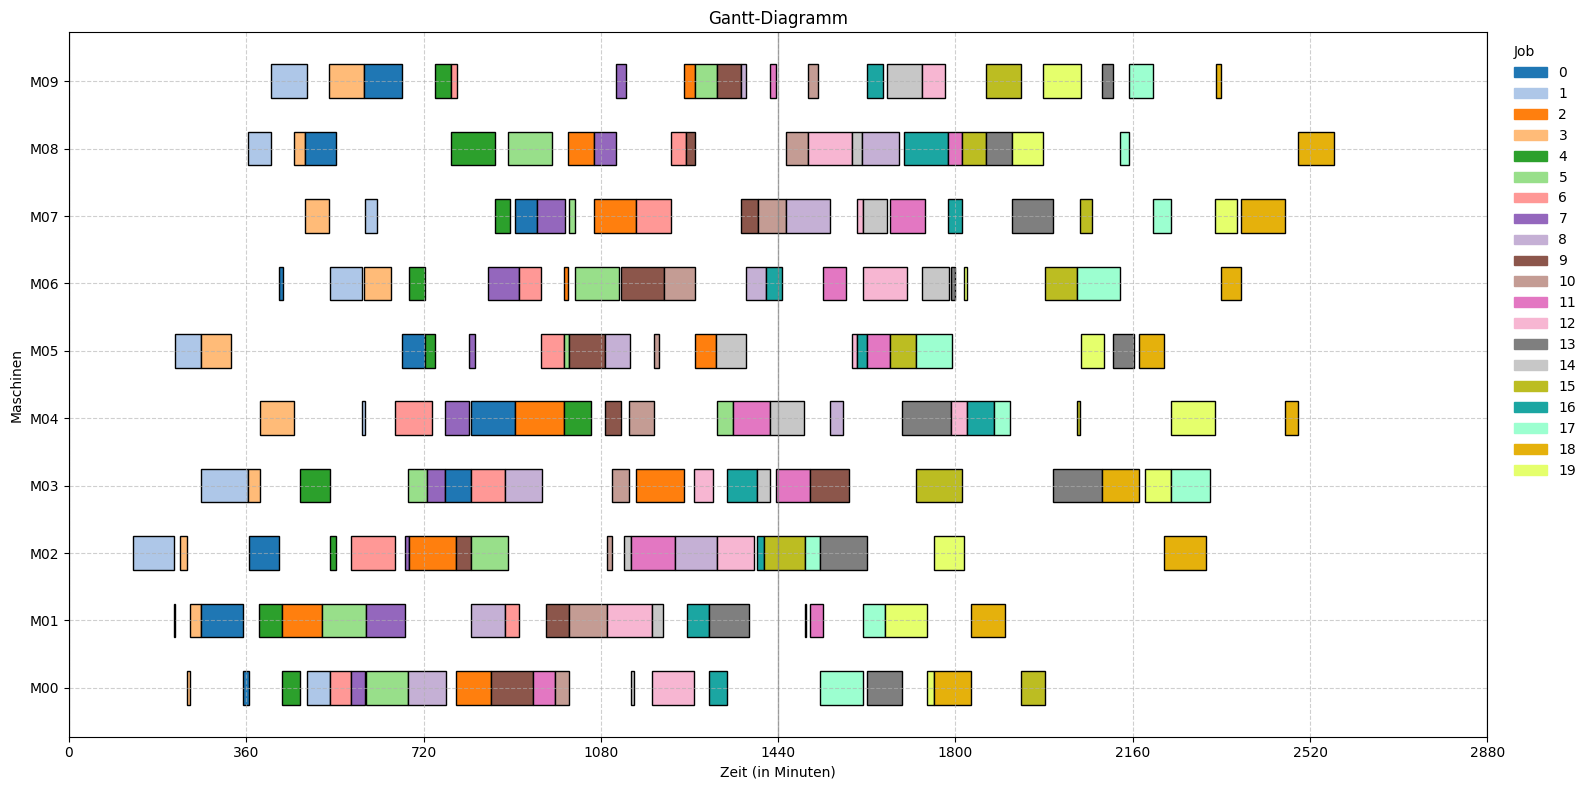

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [6]:
show.plot_gantt(df_schedule, perspective="Machine")
check.is_machine_conflict_free(df_schedule)
check.is_operation_sequence_correct(df_schedule)
check.is_job_timing_correct(df_schedule)
check.is_start_correct(df_schedule)

## II) Erster Tag (Tag 0)

### a) Simulation

In [7]:
day_length = 1440

In [8]:
day_numb = 0

day_start = day_length*day_numb 
day_end = day_start + day_length

In [9]:
simulation = ProductionSimulation(df_schedule, sigma=0.25)
df_execution = simulation.run(start_time = day_start, end_time=day_end)

[Day 0 02:10:00] Job 1 started on M02
[Day 0 03:39:38] Job 1 finished on M02 (after 89 minutes 38 seconds)
[Day 0 03:39:38] Job 1 started on M01
[Day 0 03:41:45] Job 1 finished on M01 (after 02 minutes 07 seconds)
[Day 0 03:41:45] Job 1 started on M05
[Day 0 03:46:00] Job 3 started on M02
[Day 0 03:57:13] Job 3 finished on M02 (after 11 minutes 13 seconds)
[Day 0 04:00:00] Job 3 started on M00
[Day 0 04:04:29] Job 3 finished on M00 (after 04 minutes 29 seconds)
[Day 0 04:06:00] Job 3 started on M01
[Day 0 04:28:13] Job 3 finished on M01 (after 22 minutes 14 seconds)
[Day 0 04:28:13] Job 0 started on M01
[Day 0 04:51:05] Job 1 finished on M05 (after 69 minutes 20 seconds)
[Day 0 04:51:05] Job 3 started on M05
[Day 0 04:51:05] Job 1 started on M03
[Day 0 05:42:27] Job 0 finished on M01 (after 74 minutes 13 seconds)
[Day 0 05:53:00] Job 0 started on M00
[Day 0 06:09:33] Job 0 finished on M00 (after 16 minutes 33 seconds)
[Day 0 06:09:33] Job 0 started on M02
[Day 0 06:18:17] Job 3 finishe

In [10]:
df_plan_undone = process_filter.get_unexecuted_operations(df_schedule, df_execution)
df_plan_undone 

,Job,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Tardiness
0,16,3,1254,2071.0,M02,1398.0,13.0,1411.0,0
1,10,7,922,1697.0,M07,1400.0,56.0,1456.0,0
2,16,4,1254,2071.0,M06,1415.0,32.0,1447.0,0
3,11,3,928,1929.0,M09,1424.0,11.0,1435.0,0
4,14,5,1127,1899.0,M04,1424.0,69.0,1493.0,0
...,...,...,...,...,...,...,...,...,...
75,18,5,1397,2569.0,M09,2329.0,11.0,2340.0,0
76,18,6,1397,2569.0,M06,2340.0,40.0,2380.0,0
77,18,7,1397,2569.0,M07,2380.0,89.0,2469.0,0
78,18,8,1397,2569.0,M04,2469.0,26.0,2495.0,0


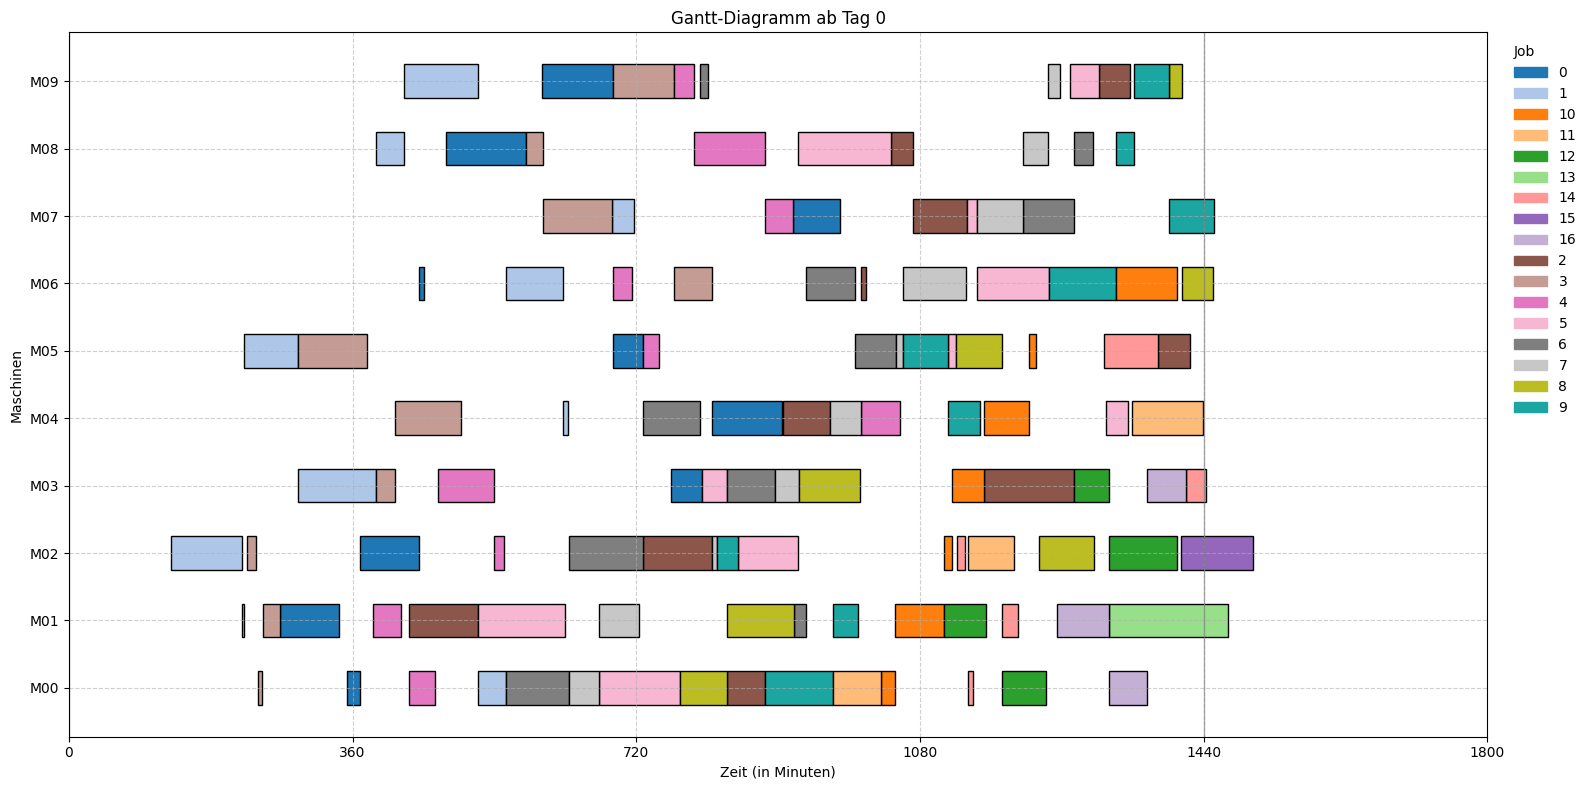

In [11]:
if not df_execution.empty:
    show.plot_gantt(df_execution, perspective="Machine", title=f"Gantt-Diagramm ab Tag {day_numb}")
else:
    print(f"Nothing executed on day {day_numb}")

### b) Verbleibene Jobs (Rest)

In [12]:
df_plan_undone 

,Job,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Tardiness
0,16,3,1254,2071.0,M02,1398.0,13.0,1411.0,0
1,10,7,922,1697.0,M07,1400.0,56.0,1456.0,0
2,16,4,1254,2071.0,M06,1415.0,32.0,1447.0,0
3,11,3,928,1929.0,M09,1424.0,11.0,1435.0,0
4,14,5,1127,1899.0,M04,1424.0,69.0,1493.0,0
...,...,...,...,...,...,...,...,...,...
75,18,5,1397,2569.0,M09,2329.0,11.0,2340.0,0
76,18,6,1397,2569.0,M06,2340.0,40.0,2380.0,0
77,18,7,1397,2569.0,M07,2380.0,89.0,2469.0,0
78,18,8,1397,2569.0,M04,2469.0,26.0,2495.0,0


In [13]:
df_job_times_undone = process_filter.update_times_after_operation_changes(df_jobs_times, df_plan_undone)
df_job_times_undone

,Job,Routing_ID,Arrival,Ready Time,Deadline
0,8,8,526,1440,1698.0
1,9,7,535,1440,1593.0
2,10,0,922,1440,1697.0
3,11,1,928,1440,1929.0
4,12,2,950,1440,2065.0
5,13,3,1001,1440,2287.0
6,14,4,1127,1440,1899.0
7,15,5,1142,1440,2116.0
8,16,6,1254,1440,2071.0
9,17,7,1285,1440,2343.0


## III) Rescheduling
> vereinfacht, ohne neu Aufträge (nur der Rest)

In [14]:
# Reduktion der bereits ausgeführten Operationen auf die relevanten für die nächsten Tage
df_execution_important = df_execution[df_execution["End"] >= 1440]
df_execution_important

,Job,Operation,Machine,Arrival,Start,Processing Time,End
86,8,6,M06,526,1412.02,40.42,1452.44
95,9,8,M07,535,1395.42,58.16,1453.58
110,13,0,M01,1001,1320.28,151.24,1471.52
115,14,4,M03,1127,1417.94,25.30,1443.24
116,15,0,M02,1142,1411.00,91.12,1502.12


In [15]:
df_reschedule = lp_tard_reschedule.solve_jssp_sum_with_fixed_ops(df_plan_undone, df_job_times_undone,
                                                                 df_execution_important,
                                                                 reschedule_start = 1440,
                                                                 solver= "HiGHS", msg=False, timeLimit=max_time, gapRel= 0.0)
df_reschedule

BigM: 4000

Solver-Informationen:
  Summe Tardiness         : 0.58
  Solver-Status           : Optimal
  Anzahl Variablen        : 447
  Anzahl Constraints      : 790
  Laufzeit                : ~2 Sekunden


,Job,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Tardiness
0,11,3,928,1929.0,M09,1440.00,11.0,1451.00,0.0
1,12,4,950,2065.0,M08,1440.00,90.0,1530.00,0.0
2,14,5,1127,1899.0,M04,1443.24,69.0,1512.24,0.0
3,10,7,922,1697.0,M07,1453.58,56.0,1509.58,0.0
4,9,9,535,1593.0,M03,1453.58,79.0,1532.58,0.0
...,...,...,...,...,...,...,...,...,...
75,18,6,1397,2569.0,M06,2325.58,40.0,2365.58,0.0
76,19,9,1398,2458.0,M07,2328.58,45.0,2373.58,0.0
77,18,7,1397,2569.0,M07,2380.00,89.0,2469.00,0.0
78,18,8,1397,2569.0,M04,2469.00,26.0,2495.00,0.0


In [16]:
last_ops = df_reschedule.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
print(show.count_column_grouped(last_ops, 'Tardiness'))

label
0            11
0 - 60        1
60 - 120      0
120 - 180     0
>180          0
Name: count, dtype: int64


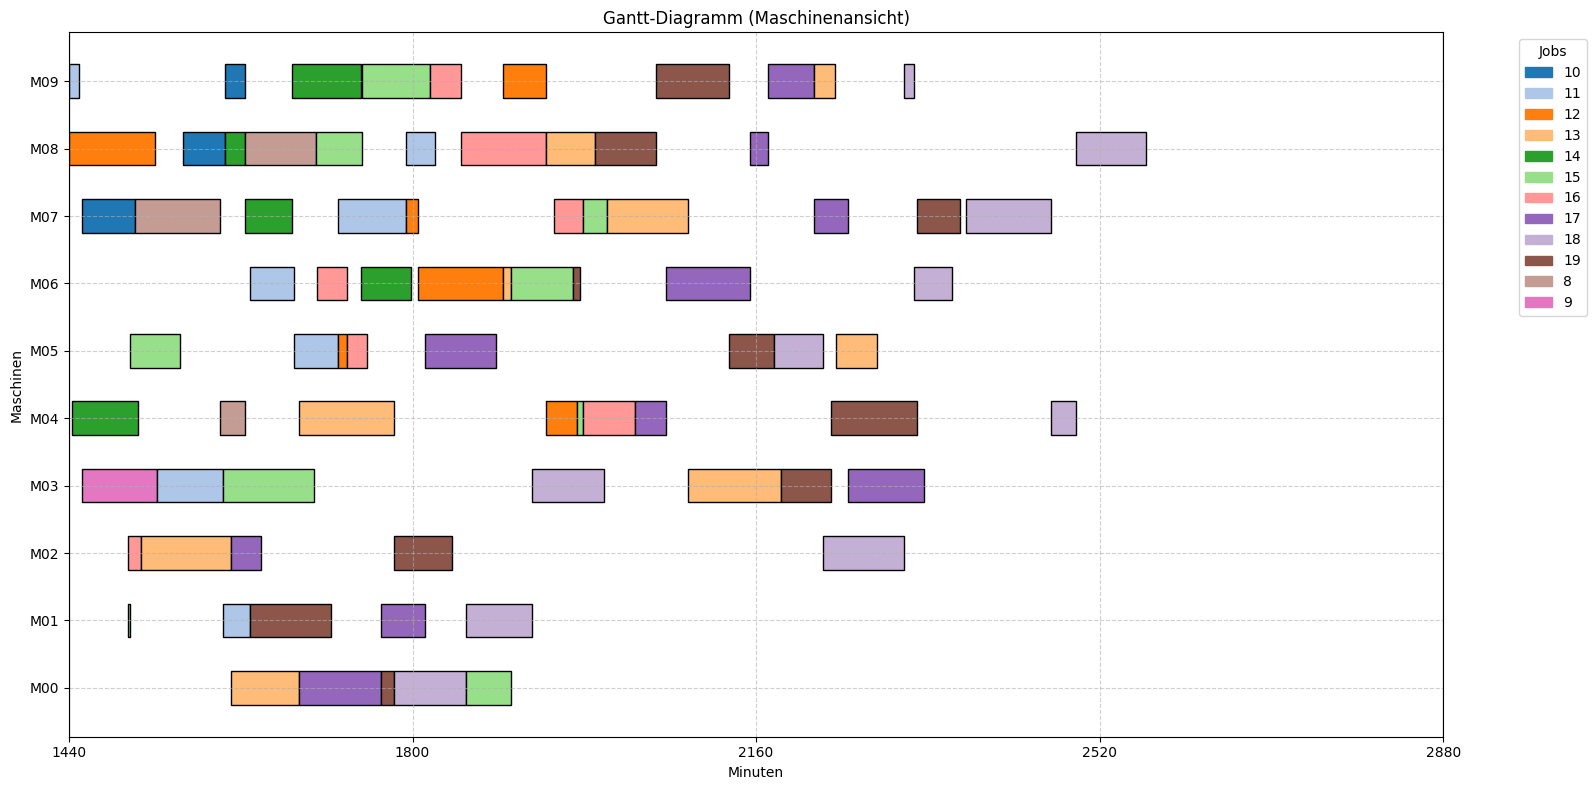

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [17]:
show.plot_gantt_machines(df_reschedule)
check.is_machine_conflict_free(df_reschedule)
check.is_operation_sequence_correct(df_reschedule)
check.is_job_timing_correct(df_reschedule)
check.is_start_correct(df_reschedule)

## Simulation + neuer Schedule 

In [18]:
df_combined = pd.concat([df_execution, df_reschedule], ignore_index=True)
df_combined

,Job,Operation,Machine,Arrival,Start,Processing Time,End,Deadline,Tardiness
0,0,0,M01,49,268.23,74.22,342.45,NaN,NaN
1,0,1,M00,49,353.00,16.55,369.55,NaN,NaN
2,0,2,M02,49,369.55,74.28,443.83,NaN,NaN
3,0,3,M06,49,443.83,6.65,450.48,NaN,NaN
4,0,4,M08,49,479.00,101.41,580.41,NaN,NaN
...,...,...,...,...,...,...,...,...,...
195,18,6,M06,1397,2325.58,40.00,2365.58,2569.0,0.0
196,19,9,M07,1398,2328.58,45.00,2373.58,2458.0,0.0
197,18,7,M07,1397,2380.00,89.00,2469.00,2569.0,0.0
198,18,8,M04,1397,2469.00,26.00,2495.00,2569.0,0.0


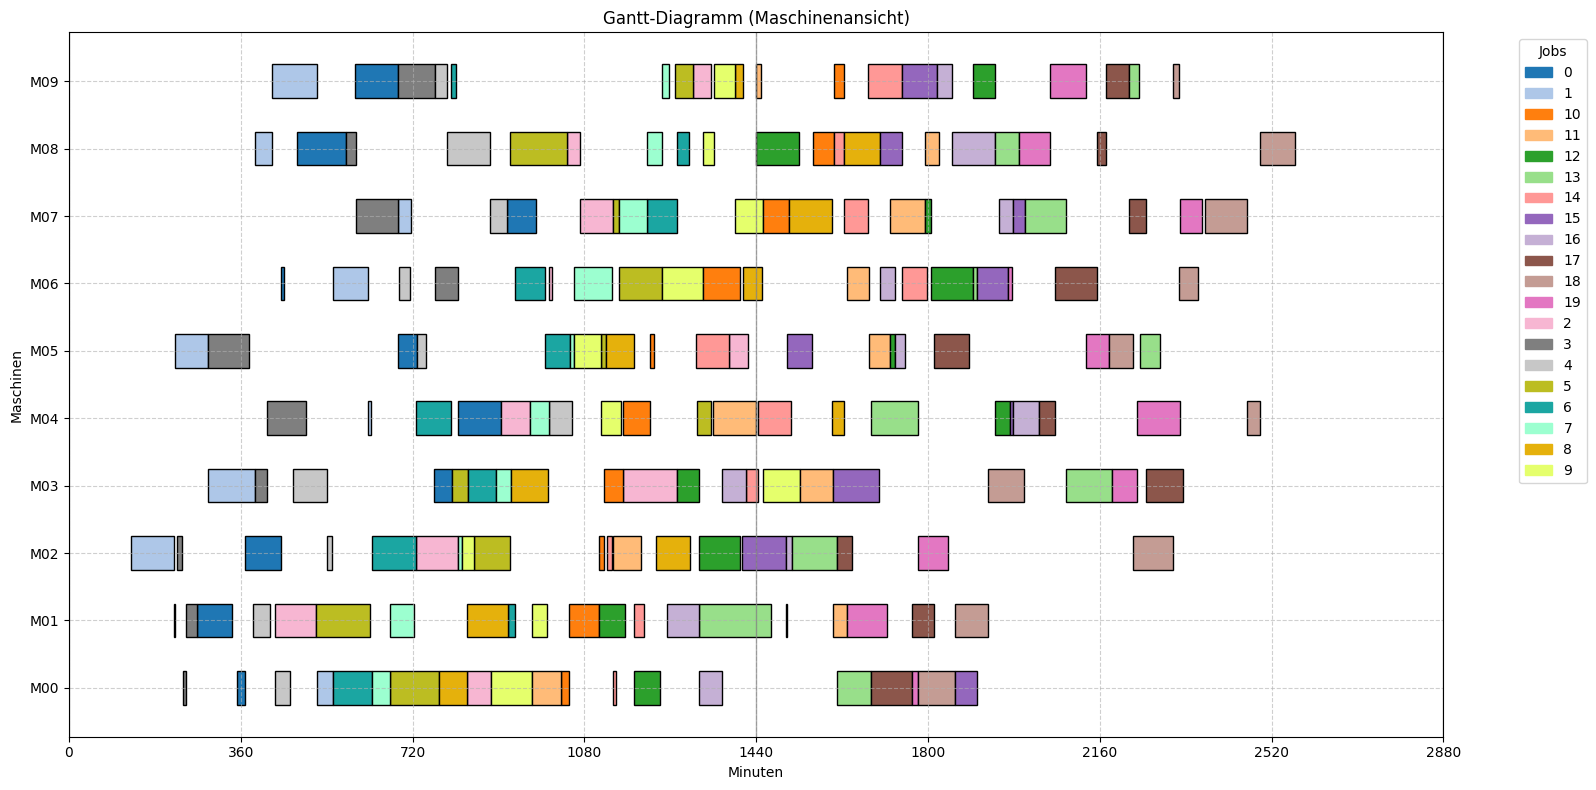

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [19]:
df = df_combined
show.plot_gantt_machines(df)
check.is_machine_conflict_free(df)
check.is_operation_sequence_correct(df)
check.is_job_timing_correct(df)
check.is_start_correct(df)